In [28]:
import os
import time
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline

#Source: https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

gpu_options = K.tf.GPUOptions(per_process_gpu_memory_fraction = 1)
config = K.tf.ConfigProto(gpu_options = gpu_options, allow_soft_placement = True)
K.set_session(K.tf.Session(config = config))

In [4]:
base_path = "/home/nbatanay/.kaggle/quora-insincere-questions-classification/"
train_df = pd.read_csv(base_path+"train.csv")
test_df = pd.read_csv(base_path+"test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [5]:
%%time
## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

CPU times: user 57.2 s, sys: 652 ms, total: 57.9 s
Wall time: 54.6 s


In [9]:
print("Train: ", train_X.shape, train_y.shape)
print("Validation: ", val_X.shape, val_y.shape)
print("Test :", test_X.shape)

Train:  (1175509, 100) (1175509,)
Validation:  (130613, 100) (130613,)
Test : (56370, 100)


### Without Embeddings

In [11]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = Conv1D(64, 3)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          330240    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 64)            49216     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
__________

In [12]:
%%time
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/3
1175509/1175509 [==============================] - 179s 152us/step - loss: 0.1248 - acc: 0.9533 - val_loss: 0.1091 - val_acc: 0.9561
Epoch 2/3
1175509/1175509 [==============================] - 178s 152us/step - loss: 0.1015 - acc: 0.9600 - val_loss: 0.1094 - val_acc: 0.9572
Epoch 3/3
1175509/1175509 [==============================] - 179s 152us/step - loss: 0.0864 - acc: 0.9657 - val_loss: 0.1172 - val_acc: 0.9556
CPU times: user 6min 36s, sys: 1min 18s, total: 7min 55s
Wall time: 8min 56s


130613/130613 [==============================] - 5s 38us/step


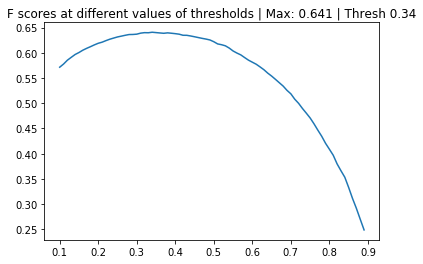

In [13]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

### Glove Embedding

In [14]:
EMBEDDING_FILE = '/home/nbatanay/.kaggle/quora-insincere-questions-classification/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

In [15]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 119s 101us/step - loss: 0.1166 - acc: 0.9535 - val_loss: 0.1038 - val_acc: 0.9588
Epoch 2/2
1175509/1175509 [==============================] - 119s 101us/step - loss: 0.0938 - acc: 0.9627 - val_loss: 0.0999 - val_acc: 0.9596


130613/130613 [==============================] - 3s 26us/step


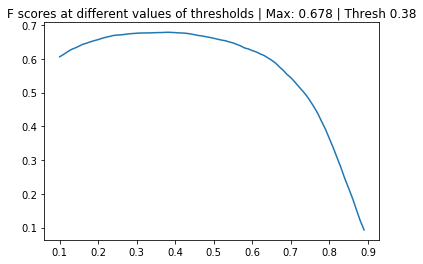

In [16]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

### Wiki-News Embedding

In [17]:
EMBEDDING_FILE = '/home/nbatanay/.kaggle/quora-insincere-questions-classification/wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total para

In [18]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 121s 103us/step - loss: 0.1162 - acc: 0.9538 - val_loss: 0.1042 - val_acc: 0.9580- loss: 0.1162 - acc: 0.953
Epoch 2/2
1175509/1175509 [==============================] - 121s 103us/step - loss: 0.0939 - acc: 0.9625 - val_loss: 0.1027 - val_acc: 0.9590


130613/130613 [==============================] - 3s 26us/step


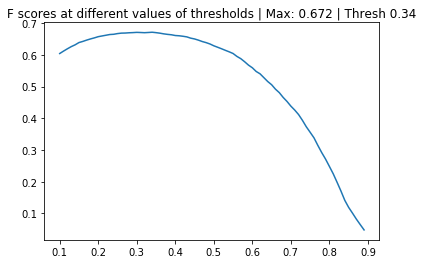

In [19]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

### Paragram Embedding

In [22]:
EMBEDDING_FILE = '/home/nbatanay/.kaggle/quora-insincere-questions-classification/paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 256)          330240    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total para

In [23]:
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/3
1175509/1175509 [==============================] - 172s 146us/step - loss: 0.1157 - acc: 0.9552 - val_loss: 0.1035 - val_acc: 0.9585
Epoch 2/3
1175509/1175509 [==============================] - 171s 146us/step - loss: 0.0954 - acc: 0.9621 - val_loss: 0.1014 - val_acc: 0.9599
Epoch 3/3
1175509/1175509 [==============================] - 170s 145us/step - loss: 0.0816 - acc: 0.9675 - val_loss: 0.1051 - val_acc: 0.9590


130613/130613 [==============================] - 5s 37us/step


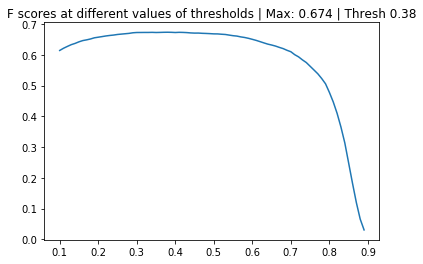

In [24]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

### Concatenate all the embeddings

In [25]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

base_path = "/home/nbatanay/.kaggle/quora-insincere-questions-classification/"
glove_file = "glove.840B.300d/glove.840B.300d.txt"
glove_index = dict(get_coefs(*o.split(" ")) for o in open(base_path+glove_file))

wiki_file = "wiki-news-300d-1M/wiki-news-300d-1M.vec"
wiki_index = dict(get_coefs(*o.split(" ")) for o in open(base_path+wiki_file) if len(o)>100)

paragram_file = "paragram_300_sl999/paragram_300_sl999.txt"
paragram_index = dict(get_coefs(*o.split(" ")) for o in open(base_path+paragram_file,
                                                             encoding="utf8", 
                                                             errors='ignore') if len(o)>100)

In [26]:
embed_index = {"glove": glove_index,
               "wiki": wiki_index,
               "paragram": paragram_index}

embedding_matrices = {}
for emb in embed_index.keys():
    all_embs = np.stack(embed_index[emb].values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embed_index[emb].get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    embedding_matrices[emb] = embedding_matrix

In [29]:
inp = Input(shape=(maxlen,))

inp_glove = Embedding(max_features, embed_size, weights=[embedding_matrices["glove"]])(inp)
inp_wiki = Embedding(max_features, embed_size, weights=[embedding_matrices["wiki"]])(inp)
inp_paragram = Embedding(max_features, embed_size, weights=[embedding_matrices["paragram"]])(inp)
merged  = concatenate([inp_glove, inp_wiki, inp_paragram])
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(merged)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 100, 300)     15000000    input_8[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 100, 300)     15000000    input_8[0][0]                    
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 100, 300)     15000000    input_8[0][0]                    
__________________________________________________________________________________________________
concatenat

In [30]:
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/3
1175509/1175509 [==============================] - 345s 293us/step - loss: 0.1094 - acc: 0.9568 - val_loss: 0.0997 - val_acc: 0.9598
Epoch 2/3
1175509/1175509 [==============================] - 343s 292us/step - loss: 0.0901 - acc: 0.9640 - val_loss: 0.0999 - val_acc: 0.9600
Epoch 3/3
1175509/1175509 [==============================] - 344s 292us/step - loss: 0.0736 - acc: 0.9706 - val_loss: 0.1100 - val_acc: 0.9586


130613/130613 [==============================] - 9s 71us/step


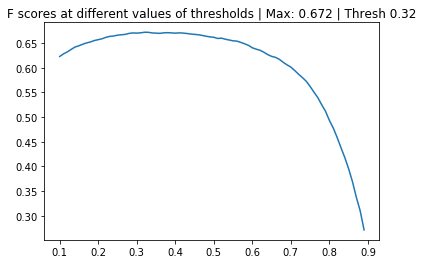

In [31]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

---

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 100, 300)     15000000    input_10[0][0]                   
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 100, 300)     15000000    input_10[0][0]                   
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 100, 300)     15000000    input_10[0][0]                   
__________________________________________________________________________________________________
bidirectio

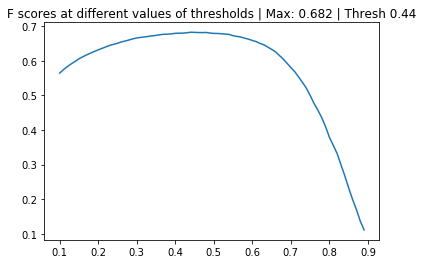

In [33]:
%%time
inp = Input(shape=(maxlen,))

inp_glove = Embedding(max_features, embed_size, weights=[embedding_matrices["glove"]])(inp)
inp_glove = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_glove)
inp_glove = GlobalMaxPool1D()(inp_glove)

inp_wiki = Embedding(max_features, embed_size, weights=[embedding_matrices["wiki"]])(inp)
inp_wiki = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_wiki)
inp_wiki = GlobalMaxPool1D()(inp_wiki)

inp_paragram = Embedding(max_features, embed_size, weights=[embedding_matrices["paragram"]])(inp)
inp_paragram = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_paragram)
inp_paragram = GlobalMaxPool1D()(inp_paragram)

merged  = concatenate([inp_glove, inp_wiki, inp_paragram])
x = Dense(16, activation="relu")(merged)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#train
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

#model performance 
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 100, 300)     15000000    input_11[0][0]                   
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 100, 300)     15000000    input_11[0][0]                   
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 100, 300)     15000000    input_11[0][0]                   
__________________________________________________________________________________________________
bidirectio

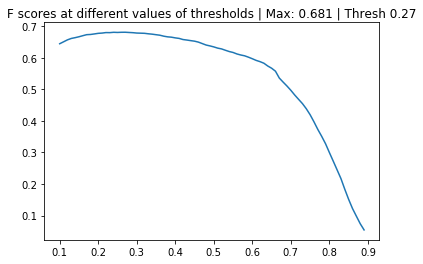

In [34]:
%%time
inp = Input(shape=(maxlen,))

inp_glove = Embedding(max_features, embed_size, weights=[embedding_matrices["glove"]])(inp)
inp_glove = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_glove)
inp_glove = GlobalMaxPool1D()(inp_glove)

inp_wiki = Embedding(max_features, embed_size, weights=[embedding_matrices["wiki"]])(inp)
inp_wiki = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_wiki)
inp_wiki = GlobalMaxPool1D()(inp_wiki)

inp_paragram = Embedding(max_features, embed_size, weights=[embedding_matrices["paragram"]])(inp)
inp_paragram = Bidirectional(CuDNNGRU(128, return_sequences=True))(inp_paragram)
inp_paragram = GlobalMaxPool1D()(inp_paragram)

merged  = concatenate([inp_glove, inp_wiki, inp_paragram])
x = Dense(32, activation="relu")(merged)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#train
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

#model performance 
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))